프로젝트 설명 및 기본 설정

In [70]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정
import matplotlib.font_manager as fm
font_path = './fonts/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'

# 현재 작업 경로 확인
current_directory = os.getcwd()
print(current_directory)

c:\Users\taehyun\github-classroom\Konkuk-Univ-Glocal-Campus\ml202401-final-taehyunkim32


1. 데이터 읽고 데이터 구조 확인

In [71]:
raw_df = pd.read_csv("./amazon_uk_shoes_products_dataset_2021_12.csv")
print(f"* 총 리뷰 개수: {raw_df.shape[0]} *")
print(raw_df.info())

* 총 리뷰 개수: 6823 *
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                6823 non-null   object 
 1   product_name       6823 non-null   object 
 2   reviewer_name      6823 non-null   object 
 3   review_title       6822 non-null   object 
 4   review_text        6814 non-null   object 
 5   review_rating      6823 non-null   float64
 6   verified_purchase  6823 non-null   bool   
 7   review_date        6823 non-null   object 
 8   helpful_count      1953 non-null   object 
 9   uniq_id            6823 non-null   object 
 10  scraped_at         6823 non-null   object 
dtypes: bool(1), float64(1), object(9)
memory usage: 539.8+ KB
None


실제데이터를 확인

In [72]:
# 첫 번째 행의 열 이름과 값을 출력
for column in raw_df.columns:
    print(f"{column} : {raw_df.iloc[0][column]}")

url : https://www.amazon.co.uk/dp/B07SBX32T5
product_name : Klasified Women's Transparent Clear Sneaker Shoe, White, 5.5 UK
reviewer_name : Jocelyn McSayles
review_title : Love em
review_text : Love these. Was looking for converses and these were half the price and so unique— I’ve never seen clear shoes like these; they fit great. The plastic takes a little getting used to but the style is so worth it.
review_rating : 5.0
verified_purchase : True
review_date : Reviewed in the United States on 2 June 2020
helpful_count : 2 people found this helpful
uniq_id : 36eae4e5-2894-5279-a0b7-d2b330e2b814
scraped_at : 24/12/2021 02:26:25


2.데이터 전처리
1)중복데이터 제거
2)주요 특성 설정
3)결측치 제거
4)노이즈 제거
5)토큰화
6)표제어 추출

1)중복 데이터 확인 및 제거
68~~개였는데 중복된 행의 개수가 364
예시 뭐시기

In [73]:
# uniq_id 열을 기준으로 중복된 행 확인
dup = raw_df.duplicated(subset=['uniq_id'], keep=False)

# 중복된 행의 개수
count_dup = dup.sum()
print(f"중복된 행의 개수: {count_dup}")

# 중복된 uniq_id 예시 추출
dup_uniq_id = raw_df['uniq_id'][raw_df['uniq_id'].duplicated()].iloc[0]

# 중복된 uniq_id 출력
print(f"중복된 uniq_id: {dup_uniq_id}")

# 중복 리뷰 케이스 확인
selected_columns = ['review_title', 'review_text', 'review_rating', 'uniq_id']
filtered_rows = raw_df[raw_df['uniq_id'] == dup_uniq_id][selected_columns]

# 결과 출력
filtered_rows

중복된 행의 개수: 364
중복된 uniq_id: d1871977-2e70-5d3d-bcb9-888819c4d0d6


,review_title,review_text,review_rating,uniq_id
1002,Per ben due volte taglia errata,Per ben due volte ho dovuto restituire l'artic...,1.0,d1871977-2e70-5d3d-bcb9-888819c4d0d6
1828,Per ben due volte taglia errata,Per ben due volte ho dovuto restituire l'artic...,1.0,d1871977-2e70-5d3d-bcb9-888819c4d0d6


원본 데이터: 6823
중복 데이터: 364
중복 데이터를 제외한 데이터: 6823 - (364 / 2) = 6641

In [74]:
# uniq_id 열을 기준으로 중복된 행 제거
df_unique = raw_df.drop_duplicates(subset=['uniq_id'], keep='first')

# 중복이 제거된 총 리뷰의 개수
count_unique = len(df_unique)
print(f"중복 데이터를 제외한 행의 개수: {count_unique}")

중복 데이터를 제외한 행의 개수: 6641


2)주요 특성 설정
`review_title`, `review_text`, `review_rating` 3가지 칼럼을 주요 특성으로 사용

In [75]:
# 사용할 columns 선택
df_selected = df_unique[["review_title", "review_text", "review_rating"]]
df_selected.head(5)

,review_title,review_text,review_rating
0,Love em,Love these. Was looking for converses and thes...,5.0
1,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0
2,Good quality,Good quality,5.0
3,Good,Great,5.0
4,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0


2)결측치 확인 및 제거

In [76]:
print(f"제목 결측치 개수: {df_selected['review_title'].isnull().sum()}")
print(f"리뷰 결측치 개수: {df_selected['review_text'].isnull().sum()}")
print(f"레이팅 결측치 개수: {df_selected['review_rating'].isnull().sum()}")

제목 결측치 개수: 1
리뷰 결측치 개수: 8
레이팅 결측치 개수: 0


제목, 리뷰에 결측치가 존재하는 행은 제거
중복 데이터를 제외한 데이터: 6823
결측치가 존재하는 데이터 : 1 + 8 = 9
결측치를 제외한 데이터: 6823 - (364 / 2) = 6641

In [78]:
df_cleaned = df_selected.dropna(subset=["review_text", "review_title"])

# 결측치가 제거된 총 리뷰의 개수
count_cleand = len(df_cleaned)
print(f"결측치를 제외한 행의 개수: {count_cleand}")

결측치를 제외한 행의 개수: 6632


,review_title,review_text,review_rating
0,Love em,Love these. Was looking for converses and thes...,5.0
1,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0
2,Good quality,Good quality,5.0
3,Good,Great,5.0
4,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0


전처리함수

In [82]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# 필요한 NLTK 데이터 다운로드
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 전처리 함수 선언
def data_preprocessing(contents):
    # 노이즈 제거 (소문자로 변환, 숫자 제거, 다중 공백 제거, 특수 문자 제거)
    contents = re.sub(r'[^\w\s]', '', re.sub(r'\s+', ' ', re.sub(r'\d+', '', contents.lower())))

    # 토큰화
    tokens = word_tokenize(contents)
    
    # 불용어 제거
    stopword = [word for word in tokens if word not in stopwords.words("english")]
    
    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in stopword]
    
    return ' '.join(tokens)

# 텍스트 전처리
df_cleaned["review_text"] = df_cleaned["review_text"].apply(data_preprocessing)
df_cleaned["review_title"] = df_cleaned["review_title"].apply(data_preprocessing)

# 전처리 완료
df = df_cleaned

df.head(10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...


,review_title,review_text,review_rating
0,love em,love looking converse half price unique ive ne...,5.0
1,plastic ripped,shoe cute nd day wearing tongue started rippin...,2.0
2,good quality,good quality,5.0
3,good,great,5.0
4,perfette,ho scelto il modello bianco con rifinitura die...,5.0
5,delusione,sono solita comprare scarpe guess e non ho mai...,1.0
6,molto belle,le scarpe sono molto belle calzano perfettamente,5.0
7,molto carine e comode,semplicemente perfette io uso plantari su misu...,5.0
8,bellissimepeccato per il numero,le scarpe sono bellissime arrivate perfetto st...,5.0
9,scarpe ben realizzate venditore ottimo,le scarpe sono ben fatte e il venditore molto ...,5.0


3. 모델구현


In [87]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK 패키지 다운로드
nltk.download("vader_lexicon")

# VADER 감성 분석기 초기화
vader_sentiment = SentimentIntensityAnalyzer()

# 감성 계산 함수 선언
def calc_sentiment(review): 
    # VADER 감성 분석기를 사용하여 'compound' 스코어를 반환
    return vader_sentiment.polarity_scores(review)["compound"]

# 감성 점수 계산 및 데이터 프레임에 추가
# review_title과 review_text에 calc_sentiment 함수를 적용 후 결과를 df에 추가
df["title_compound"] = df.review_title.apply(calc_sentiment)
df["text_compound"] = df.review_text.apply(calc_sentiment)

df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,review_title,review_text,review_rating,title_compound,text_compound
0,love em,love looking converse half price unique ive ne...,5.0,0.6369,0.9188
1,plastic ripped,shoe cute nd day wearing tongue started rippin...,2.0,0.0000,0.2240
2,good quality,good quality,5.0,0.4404,0.4404
3,good,great,5.0,0.4404,0.6249
4,perfette,ho scelto il modello bianco con rifinitura die...,5.0,0.0000,-0.4588
...,...,...,...,...,...
6818,schick und leicht,schicker schuh läuft sich gut,5.0,0.0000,0.0000
6819,excellent,mieux que je ne limaginais très bonne taille b...,5.0,0.5719,0.0000
6820,einfach schöne hausschuhe,habe sie al geschenk gekauft und sie sind sehr...,5.0,0.0000,0.5994
6821,langlebig,trage diese hausschuhe fast zwei monate jeden ...,5.0,0.0000,-0.7845


In [88]:
# title_compound와 text_compound의 평균을 계산하여 Sentiment_Score 칼럼에 추가
df["Sentiment_Score"] = (df["title_compound"] + df["text_compound"]) / 2

df[["review_title", "review_text", "review_rating", "Sentiment_Score"]].head(10)

,review_title,review_text,review_rating,Sentiment_Score
0,love em,love looking converse half price unique ive ne...,5.0,0.77785
1,plastic ripped,shoe cute nd day wearing tongue started rippin...,2.0,0.11200
2,good quality,good quality,5.0,0.44040
3,good,great,5.0,0.53265
4,perfette,ho scelto il modello bianco con rifinitura die...,5.0,-0.22940
5,delusione,sono solita comprare scarpe guess e non ho mai...,1.0,0.00000
6,molto belle,le scarpe sono molto belle calzano perfettamente,5.0,0.00000
7,molto carine e comode,semplicemente perfette io uso plantari su misu...,5.0,0.00000
8,bellissimepeccato per il numero,le scarpe sono bellissime arrivate perfetto st...,5.0,0.00000
9,scarpe ben realizzate venditore ottimo,le scarpe sono ben fatte e il venditore molto ...,5.0,0.17000


In [102]:
# Sentiment_Score 점수를 기준으로 감성 레이블 생성 (긍정 1, 부정 0)
def sentiment_label(score):
    if score >= 0:
        return 1
    else:
        return 0

df["label"] = df["Sentiment_Score"].apply(sentiment_label)

df[["review_title", "review_text", "review_rating", "Sentiment_Score", "label"]].head(10)

,review_title,review_text,review_rating,Sentiment_Score,label
0,love em,love looking converse half price unique ive ne...,5.0,0.77785,1
1,plastic ripped,shoe cute nd day wearing tongue started rippin...,2.0,0.11200,1
2,good quality,good quality,5.0,0.44040,1
3,good,great,5.0,0.53265,1
4,perfette,ho scelto il modello bianco con rifinitura die...,5.0,-0.22940,0
5,delusione,sono solita comprare scarpe guess e non ho mai...,1.0,0.00000,1
6,molto belle,le scarpe sono molto belle calzano perfettamente,5.0,0.00000,1
7,molto carine e comode,semplicemente perfette io uso plantari su misu...,5.0,0.00000,1
8,bellissimepeccato per il numero,le scarpe sono bellissime arrivate perfetto st...,5.0,0.00000,1
9,scarpe ben realizzate venditore ottimo,le scarpe sono ben fatte e il venditore molto ...,5.0,0.17000,1


오실패함

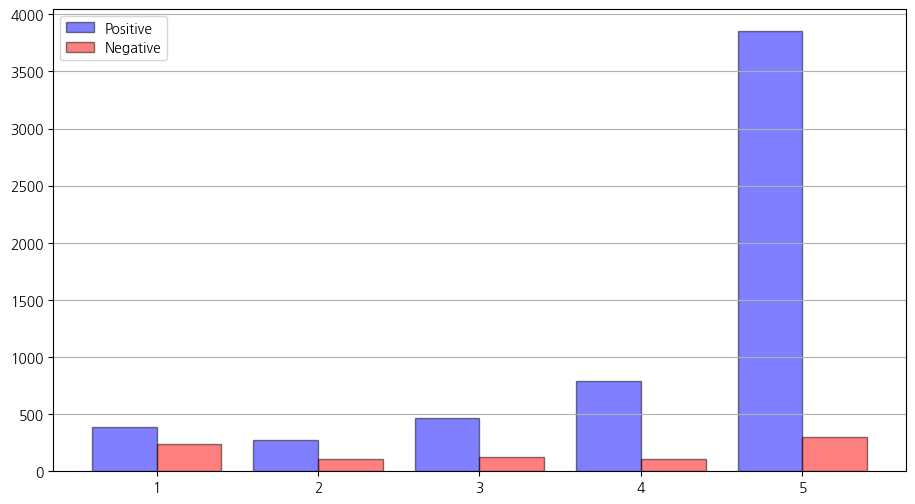

In [100]:
# 긍정, 부정 라벨 데이터 분리
positive = df[df['label'] == 1]['review_rating']
negative = df[df['label'] == 0]['review_rating']

# 히스토그램 설정
plt.figure(figsize=(11, 6))

plt.hist([positive, negative], bins=range(1, 7), label=["Positive", "Negative"], color=['blue', 'red'],alpha=0.5, edgecolor='black', align='left')
plt.legend(loc="upper left")
plt.grid(axis='y')

plt.show()

Sentiment_Score는 -1에서 1까지 인것을 확인 할 수 있다.

In [108]:
# 최저 Sentiment_Score
print(df['Sentiment_Score'].min())

# 최고 Sentiment_Score
print(df['Sentiment_Score'].max())

-0.8726
0.9601500000000001


great kind super와 같이 긍정적인 단어가 보인 리뷰에서는 높은 점수를 받았습니다.

In [110]:
# Sentiment_Score 높은 순
df.sort_values(by='Sentiment_Score', ascending=False).head(5)

,review_title,review_text,review_rating,title_compound,text_compound,Sentiment_Score,label
5427,great shoe great price fit kind weird,great shoe little surprised got shoe noticed g...,4.0,0.9246,0.9957,0.96015,1
553,super comfortable stylish great quality easy c...,wider foot fit great super comfortable easy wa...,5.0,0.9509,0.9618,0.95635,1
2320,love love love,usually wear based review ordered half size sm...,5.0,0.9274,0.9831,0.95525,1
3900,comfortable great support awesome value,arrived speak durability yet im thrilled shoe ...,5.0,0.9485,0.9566,0.95255,1
5840,perfect fit amazing quality comfort,awesome highquality comfortable shoe cant say ...,5.0,0.9100,0.9914,0.95070,1


die와 같이 부정적인 단어가 보인 리뷰에서는 낮은 점수를 받았습니다.

*리뷰가 영어로 적혀있지 않은 것으로 보이나 영어로 판독하여 부정적인 결과가 나온 것 같습니다.*

In [111]:
# Sentiment_Score 낮은 순
df.sort_values(by='Sentiment_Score').head(5)

,review_title,review_text,review_rating,title_compound,text_compound,Sentiment_Score,label
5263,die bequemsten schuhe die ich jemals getragen ...,auf der suche nach bequemen sneakern sind mir ...,5.0,-0.8316,-0.9136,-0.87260,0
2103,die qualität hat extrem nachgelassen,ich habe zwei jacken bestellt farben limette u...,1.0,-0.5994,-0.9955,-0.79745,0
2108,nicht dicht vorsicht achtet drauf wer die stie...,wir sind sehr enttäuscht die stiefel x angehab...,1.0,-0.5994,-0.9661,-0.78275,0
2961,die dicke sohle ist sehr gelenkfreundlich mein...,ich habe mir gedacht das diese schuhe eine gut...,5.0,-0.5994,-0.9601,-0.77975,0
4993,endlich ein idealer winterschuh auch für frau ...,al berufspendler der täglich lange zeit mit öf...,4.0,-0.5994,-0.9565,-0.77795,0


잘못 예측될만한 상황이 있음에도 불구하고 생각보다 높은 정확성을 보였다.
약 80퍼센트의 정확성을 띄는 것을 알 수 있다.

In [113]:
# Sentiment_Score와 review_rating 매칭 함수 선언
good = 0
bad = 0

for i in range(len(df)):
    if (df.iloc[i, 2] >= 3.0 and df.iloc[i, 6] == 1) or (df.iloc[i, 2] < 3.0 and df.iloc[i, 6] == 0):
        good += 1
    else:
        bad += 1

# 결과 출력
print("정확한 분석 : ", good)
print("비정확한 분석 : ", bad)

정확한 분석 :  5450
비정확한 분석 :  1182


4.모델 학습 및 튜닝

In [118]:
# 필요한 sklearn 패키지 설치
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

- review_title과 review_text 칼럼을 하나의 칼럼으로 합친 후 TF_IDF 백터화 진행
- TF-IDF 벡터화는 문자열 리스트를 학습을 위해 벡터로 바꿔주는 작업
- 로지스틱 회귀 모델 학습 및 평가를 위해 데이터셋 분할
- 학습 데이터와 평가 데이터는 8:2 비율로 분할

In [115]:
# y값 지정
y = df["label"]

# 제목과 리뷰 내용을 합치기
df["total"] = df["review_title"] + " " + df["review_text"]

# TF-IDF 백터화
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["total"])

# 학습 데이터와 테스트 데이터로 8:2 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- 로지스틱 회귀 모델 사용
- 하이퍼마라미터 튜닝 기법으로 그리드 서치 사용
- C와 max_iter에 대한 하이퍼파라미터 튜닝 진행
- 교차 검증을 위한 fold 횟수는 5회로 지정

In [116]:
# 로지스틱 회귀 모델 초기화
model = LogisticRegression()

# 하이퍼파라미터 그리드 설정
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [100, 1000]
}

# 그리드 서치 객체 생성 (모델, 하이퍼파라미터, 교차 검증 횟수, 성능 평가 지표 설정)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")

# 그리드 서치 실행 (훈련 데이터에 맞추어 모델 학습)
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터와 테스트 정확도 출력
print("최적 파라미터:", grid_search.best_params_)
print("테스트 정확도:", grid_search.score(X_test, y_test))

최적 파라미터: {'C': 10, 'max_iter': 100}
테스트 정확도: 0.9397136397889977


- 그리드 서치를 통해 알아낸 최적의 하이퍼파라미터 값은 C가 10, max_iter가 100
- 최적의 하이퍼파라미터 값으로 모델 학습

In [117]:
# 그리드 서치를 통해 찾은 최적의 모델
best_model = grid_search.best_estimator_

# 훈련 데이터를 사용하여 최적 모델 학습
best_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측값 생성
y_pred = best_model.predict(X_test)

5.모델 평가

In [121]:
# 정확도 평가
print(f"정확도: {accuracy_score(y_test, y_pred):.5f}")

# 정밀도 평가
print(f"정밀도: {precision_score(y_test, y_pred, average='weighted'):.5f}")

# 재현율 평가
print(f"재현율: {recall_score(y_test, y_pred, average='weighted'):.5f}")

# F1 점수 평가
print(f"F1-점수: {f1_score(y_test, y_pred, average='weighted'):.5f}")

# ROC-AUC 점수
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.5f}")

# 모델 성능 평가
print(classification_report(y_test, y_pred))

정확도: 0.93971
정밀도: 0.93817
재현율: 0.93971
F1-점수: 0.93455
ROC-AUC: 0.80030
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       177
           1       0.94      0.99      0.97      1150

    accuracy                           0.94      1327
   macro avg       0.93      0.80      0.85      1327
weighted avg       0.94      0.94      0.93      1327



6.시각화

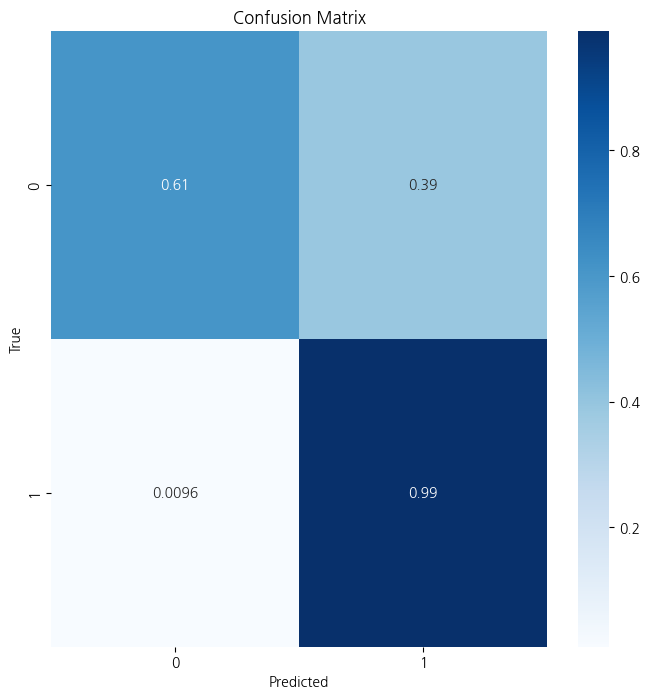

In [126]:
# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred, labels = None, sample_weight = None, normalize = 'true')

# 혼동 행렬 시각화
plt.figure(figsize = (8, 8))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues')

# tittle 설정
plt.title('Confusion Matrix')

# x축 라벨 설정
plt.xlabel('Predicted')

# y축 라벨 설정
plt.ylabel('True')

plt.show()

roc

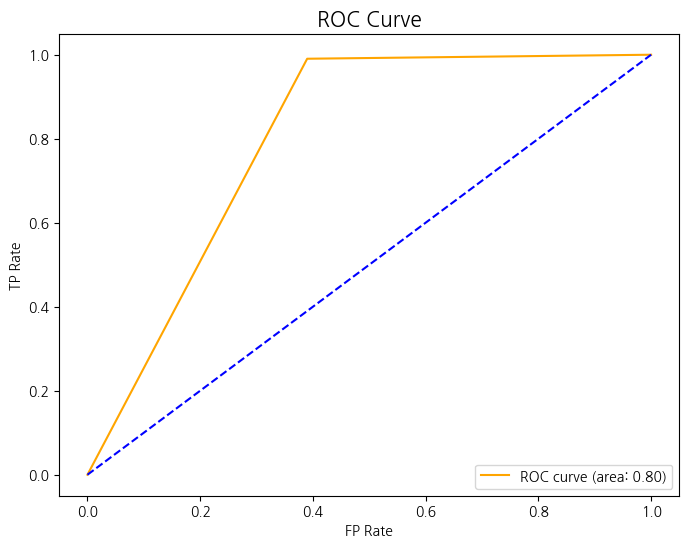

In [127]:
# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# ROC 곡선 아래 면적 계산
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

# x축은 fpr, y축은 tpr인 그래프 생성, 라벨로 roc_auc (면적의 넓이) 표시
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (area: {roc_auc:.2f})")

# 기준선 출력 (y=x 그래프)
plt.plot([0, 1], [0, 1], color="blue", linestyle="--") 

# tittle 설정
plt.title('ROC Curve', fontsize=15)

# 범례 설정
plt.legend(loc='lower right')

# x축 라벨 설정
plt.xlabel("False Positive Rate")

# y축 라벨 설정
plt.ylabel("True Positive Rate")

plt.show()

In [ ]:
7.마무리